# Image Segmentation

In [0]:
import os
!pip install -q fastai2 fastcore torch torchvision feather-format kornia pyarrow wandb nbdev fastprogress --upgrade 
!pip install Pillow==6.2.1 --upgrade
os._exit(00)

     |████████████████████████████████| 122kB 4.7MB/s 
     |████████████████████████████████| 59.2MB 153kB/s 
     |████████████████████████████████| 2.1MB 45.1MB/s 
     |████████████████████████████████| 1.3MB 51.3MB/s 
     |████████████████████████████████| 460kB 77.1MB/s 
     |████████████████████████████████| 102kB 14.9MB/s 
     |████████████████████████████████| 92kB 13.4MB/s 
     |████████████████████████████████| 256kB 74.6MB/s 
     |████████████████████████████████| 92kB 14.5MB/s 
     |████████████████████████████████| 71kB 12.5MB/s 
     |████████████████████████████████| 184kB 67.2MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


What is segmentation?

* Pixel-wise classes
* Used for fine-grained image segmenting

![](https://www.researchgate.net/profile/Anna_Boers/publication/235885350/figure/fig2/AS:299772243136518@1448482680597/Example-of-incorrect-automated-segmentation-due-to-hemorrhage-and-erroneous-midline.png)
[URL](https://www.researchgate.net/profile/Anna_Boers/publication/235885350/figure/fig2/AS:299772243136518@1448482680597/Example-of-incorrect-automated-segmentation-due-to-hemorrhage-and-erroneous-midline.png)

![](https://d2908q01vomqb2.cloudfront.net/f1f836cb4ea6efb2a0b1b99f41ad8b103eff4b59/2018/11/26/semantic-segmentation-1.jpg)
[URL](https://d2908q01vomqb2.cloudfront.net/f1f836cb4ea6efb2a0b1b99f41ad8b103eff4b59/2018/11/26/semantic-segmentation-1.jpg)

# Libraries

In [0]:
from fastai2.basics import *
from fastai2.vision.all import *
from fastai2.callback.all import *

# Dataset

Todays dataset will be `CAMVID`, which is a segmentation based problem from cameras on cars to segment various areas of the road

In [4]:
path = untar_data(URLs.CAMVID)

Our validation set is inside a text document called `valid.txt` and split by new lines. Let's read it in:

In [0]:
valid_fnames = (path/'valid.txt').read().split('\n')

In [6]:
valid_fnames[:5]

['0016E5_07959.png',
 '0016E5_07961.png',
 '0016E5_07963.png',
 '0016E5_07965.png',
 '0016E5_07967.png']

Let's look at an image and see how everything aligns up

In [0]:
path_im = path/'images'
path_lbl = path/'labels'

First we need our filenames

In [0]:
fnames = get_image_files(path_im)
lbl_names = get_image_files(path_lbl)

And now let's work with one of them

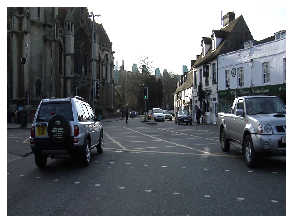

In [9]:
img_fn = fnames[10]
img = PILImage.create(img_fn)
img.show(figsize=(5,5))

Now let's grab our y's. They live in the `labels` folder and are denoted by a `_P`

In [0]:
get_msk = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}'

The stem and suffix grab everything before and after the period respectively.

Our masks are of type `PILMask` and we will make our gradient percentage (alpha) equal to 1 as we are not overlaying this on anything yet

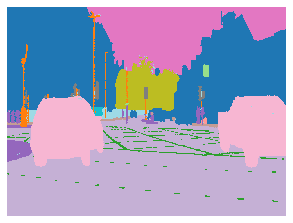

In [11]:
msk = PILMask.create(get_msk(img_fn))
msk.show(figsize=(5,5), alpha=1)

Now if we look at what our mask actually is, we can see it's a giant array of pixels:

In [12]:
tensor(msk)

tensor([[ 4,  4,  4,  ..., 21, 21, 21],
        [ 4,  4,  4,  ..., 21, 21, 21],
        [ 4,  4,  4,  ..., 21, 21, 21],
        ...,
        [17, 17, 17,  ..., 17, 17, 17],
        [17, 17, 17,  ..., 17, 17, 17],
        [17, 17, 17,  ..., 17, 17, 17]], dtype=torch.uint8)

Where each one represents a class that we can find in `codes.txt`. Let's make a vocabulary with it

In [13]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car',
       'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv',
       'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving',
       'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk',
       'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel',
       'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

We need a split function that will split from our list of valid filenames we grabbed earlier. Let's try making our own.

In [0]:
def ListSplitter(items):
  def _inner(it):
    val_mask = tensor([o.name in items for o in it])
    return [~val_mask, val_mask]
  return _inner

This takes in our filenames, and checks for all of our filenames in all of our items in our validation filenames

# Transfer Learning between DataSets

Jeremy popularized the idea of image resizing:
* Train on smaller sized images
* Eventually get larger and larger
* Transfer Learning loop

In [0]:
camvid = DataBlock(blocks=(ImageBlock, ImageBlock(cls=PILMask)),
                   get_items=get_image_files,
                   splitter=ListSplitter(valid_fnames),
                   get_y=get_msk)

This first round we will train at half the image size

In [16]:
sz = msk.shape; sz

(720, 960)

In [17]:
half = tuple(int(x/2) for x in sz); half

(360, 480)

In [0]:
dbunch = camvid.databunch(path/'images', bs=8,
                          batch_tfms=[*aug_transforms(size=half), Normalize.from_stats(*imagenet_stats)])

Let's look at a batch, and look at all the classes between codes 1 and 30 (ignoring `Animal` and `Wall`)

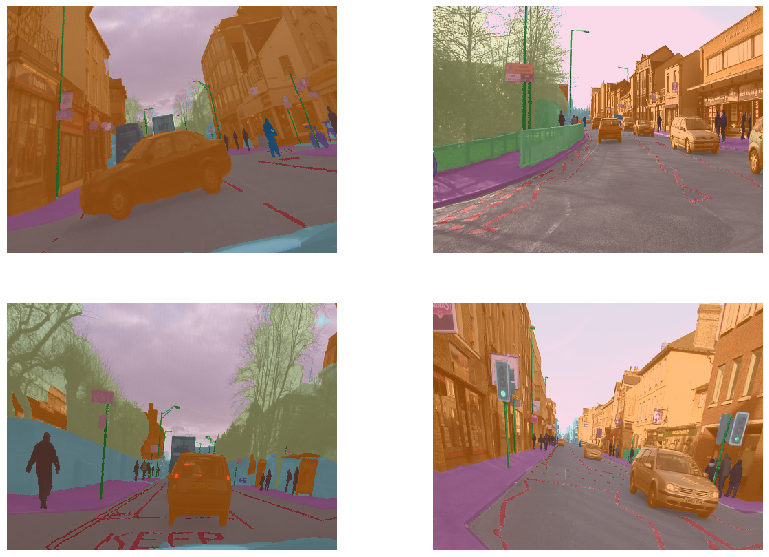

In [19]:
dbunch.show_batch(max_n=4, vmin=1, vmax=30, figsize=(14,10))

Lastly let's make our vocabulary a part of our `DataBunch`, as our loss function needs to deal with the `Void` label

In [0]:
dbunch.vocab = codes

Now we need a methodology for grabbing that particular code from our output of numbers. Let's make everything into a dictionary

In [0]:
name2id = {v:k for k,v in enumerate(codes)}

In [22]:
name2id

{'Animal': 0,
 'Archway': 1,
 'Bicyclist': 2,
 'Bridge': 3,
 'Building': 4,
 'Car': 5,
 'CartLuggagePram': 6,
 'Child': 7,
 'Column_Pole': 8,
 'Fence': 9,
 'LaneMkgsDriv': 10,
 'LaneMkgsNonDriv': 11,
 'Misc_Text': 12,
 'MotorcycleScooter': 13,
 'OtherMoving': 14,
 'ParkingBlock': 15,
 'Pedestrian': 16,
 'Road': 17,
 'RoadShoulder': 18,
 'SUVPickupTruck': 22,
 'Sidewalk': 19,
 'SignSymbol': 20,
 'Sky': 21,
 'TrafficCone': 23,
 'TrafficLight': 24,
 'Train': 25,
 'Tree': 26,
 'Truck_Bus': 27,
 'Tunnel': 28,
 'VegetationMisc': 29,
 'Void': 30,
 'Wall': 31}

Awesome! Let's make an accuracy function

In [0]:
void_code = name2id['Void']

For segmentation, we want to squeeze all the outputted values to have it as a matrix of digits for our segmentation mask. From there, we want to match their argmax to the target's mask for each pixel and take the average

In [0]:
def acc_camvid(inp, targ):
  targ = targ.squeeze(1)
  mask = targ != void_code
  return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()

# Model

## U-Net

![](http://deeplearning.net/tutorial/_images/unet.jpg)

U-Net allows us to look at pixel-wise representations of our images through sizing it down and then blowing it bck up into a high resolution image. The first part we call an "encoder" and the second a "decoder"

On the image, the authors of the UNET paper describe the arrows as "denotions of different operations"

We have a special `unet_learner`. Something new is we can pass in a configuration(`unet_config`) where we can declare a few things!

* Blur/blur final: avoid checkerboard artifacts
* Self attention: A self-attention layer
* y_range: Last activations go through a sigmoid for rescaling
* Last cross - Cross-connection with the direct model input
* Bottle - Bottlenck or not on that cross
* Activation function
* Norm type

Let's make a `unet_learner` that uses some of the new state of the art techniques. Specifically:

* Self-attention layers: `self_attention = True`
* Mish activation function: `act_cls = MishJit`

In [0]:
config = unet_config(self_attention=True, act_cls=MishJit)

Along with this we will use the `Ranger` activation function

In [0]:
opt = ranger

In [29]:
learn = unet_learner(dbunch, resnet34, metrics=acc_camvid, config=config,
                     opt_func=opt)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 272MB/s]


In [30]:
learn.summary()

DynamicUnet (Input shape: 8 x 3 x 360 x 480)
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               8 x 64 x 180 x 240   9,408      False     
________________________________________________________________
BatchNorm2d          8 x 64 x 180 x 240   128        True      
________________________________________________________________
ReLU                 8 x 64 x 180 x 240   0          False     
________________________________________________________________
MaxPool2d            8 x 64 x 90 x 120    0          False     
________________________________________________________________
Conv2d               8 x 64 x 90 x 120    36,864     False     
________________________________________________________________
BatchNorm2d          8 x 64 x 90 x 120    128        True      
________________________________________________________________
ReLU                 8 x 64 x 90 x 120    0          False     
_____________________________________________________

If we do a `learn.summary` we can see this blow-up trend, and see that our model came in frozen. Let's find a learning rate

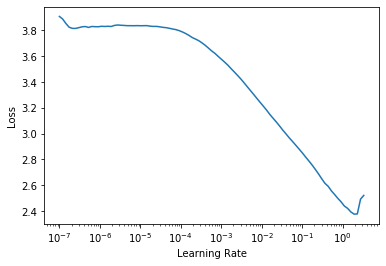

In [31]:
learn.lr_find()

In [0]:
lr = 4e-3

With our new optimizer, we will also want to use a different fit function, called `fit_flat_cos`

In [35]:
learn.fit_flat_cos(10, slice(lr))

epoch,train_loss,valid_loss,acc_camvid,time
0,2.020777,1.509037,0.823573,01:04
1,1.566917,1.211573,0.856447,00:59
2,1.280488,1.034891,0.870754,00:59
3,1.063346,0.786943,0.900439,00:59
4,0.891845,0.737360,0.889325,00:58
5,0.751850,0.576657,0.905601,00:59
6,0.641239,0.520399,0.903509,00:59
7,0.555568,0.443694,0.911673,00:59
8,0.485420,0.372818,0.925448,00:59
9,0.428019,0.374810,0.921385,00:59


Now what exactly was `fit_flat_cos` doing here?

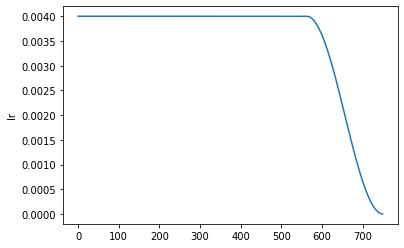

In [37]:
learn.recorder.plot_sched()

As we can see, as we got to our 600th batch we dropped our learning rate

In [40]:
len(learn.dbunch.train_dl) * 10

750

And it applies over the **entire** training time

In [0]:
learn.save('stage-1')
learn.load('stage-1');

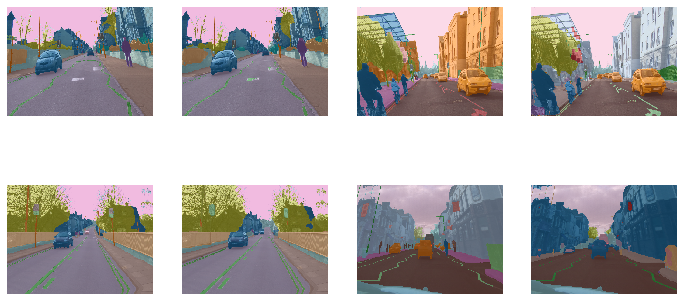

In [47]:
learn.show_results(max_n=4, figsize=(12,6))

Let's unfreeze the model and decrease our learning rate by 4 (Rule of thumb)

In [0]:
lrs = slice(lr/400, lr/4)

In [49]:
lr, lrs

(0.004, slice(1e-05, 0.001, None))

In [0]:
learn.unfreeze()

And train for a bit more

In [51]:
learn.fit_flat_cos(12, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.406243,0.375707,0.919977,01:01
1,0.399520,0.370884,0.920931,01:01
2,0.382349,0.358365,0.923526,01:01
3,0.364121,0.344907,0.923763,01:01
4,0.351676,0.349616,0.924491,01:01
5,0.336476,0.331534,0.925147,01:01
6,0.322429,0.334252,0.921857,01:01
7,0.311658,0.334523,0.922462,01:01
8,0.297568,0.296011,0.931343,01:01
9,0.286248,0.304708,0.926816,01:01


Now let's save that model away

In [0]:
learn.save('model_1')

And look at a few results

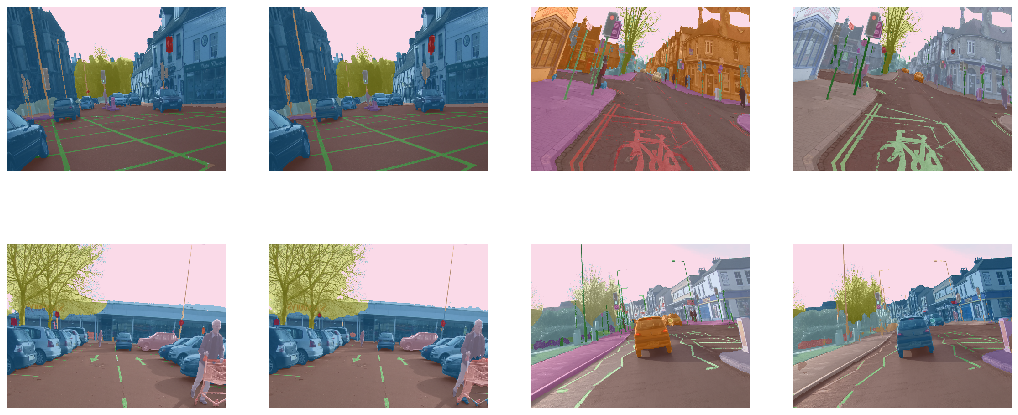

In [53]:
learn.show_results(max_n=4, figsize=(18,8))

# Full Size

Now let's go full sized. Restart your instance to re-free your memory

In [0]:
from fastai2.basics import *
from fastai2.vision.all import *
from fastai2.callback.all import *

In [0]:
path = untar_data(URLs.CAMVID)
valid_fnames = (path/'valid.txt').read().split('\n')
get_msk = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}'
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

def ListSplitter(items):
  def _inner(it):
    val_mask = tensor([o.name in items for o in it])
    return [~val_mask, val_mask]
  return _inner

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(inp, targ):
  targ = targ.squeeze(1)
  mask = targ != void_code
  return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()

And re-make our databunch. But this time we want our size to be the full size

In [0]:
camvid = DataBlock(blocks=(ImageBlock, ImageBlock(cls=PILMask)),
                   get_items=get_image_files,
                   splitter=ListSplitter(valid_fnames),
                   get_y=get_msk)

We'll also want to lower our batch size to not run out of memory

In [0]:
dbunch = camvid.databunch(path/"images", bs=1,
                          batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)])

Let's assign our vocab, make our learner, and load our weights

In [0]:
config = unet_config(self_attention=True, act_cls=MishJit)
opt = ranger

In [0]:
dbunch.vocab = codes
learn = unet_learner(dbunch, resnet34, metrics=acc_camvid, config=config,
                     opt_func=opt)
learn.load('model_1');

And now let's find our learning rate and train!

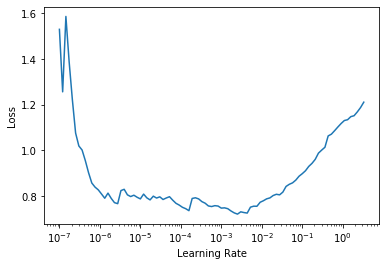

In [9]:
learn.lr_find()

In [0]:
lr = 1e-3

In [12]:
learn.fit_flat_cos(10, slice(lr))

epoch,train_loss,valid_loss,acc_camvid,time
0,0.506793,0.342499,0.926143,05:15
1,0.430471,0.331063,0.924518,05:14
2,0.349916,0.330467,0.915646,05:14
3,0.330413,0.291114,0.926524,05:13
4,0.307470,0.273733,0.928941,05:13
5,0.281810,0.278765,0.926421,05:12
6,0.250463,0.288746,0.923950,05:12
7,0.248945,0.284137,0.923201,05:11
8,0.214759,0.256868,0.931487,05:10
9,0.188897,0.267987,0.928474,05:10


In [0]:
learn.save('full_1')

In [0]:
learn.unfreeze()

In [17]:
lrs = slice(1e-6,lr/10); lrs

slice(1e-06, 0.0001, None)

In [18]:
learn.fit_flat_cos(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.187095,0.266967,0.926938,05:20
1,0.186410,0.262047,0.928341,05:20
2,0.190994,0.282032,0.922368,05:19
3,0.186702,0.262346,0.929233,05:19
4,0.179937,0.270361,0.925767,05:19
5,0.176367,0.270718,0.926208,05:19
6,0.176295,0.259349,0.928089,05:19
7,0.171654,0.260007,0.928189,05:19
8,0.170364,0.261180,0.928160,05:19
9,0.160006,0.253466,0.929910,05:19


In [0]:
learn.save('full_2')

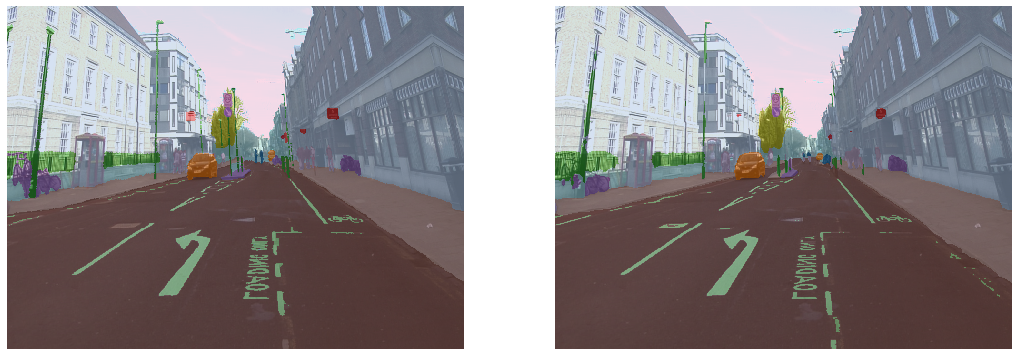

In [21]:
learn.show_results(max_n=4, figsize=(18,8))